# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

In [2]:
#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']


# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)

In [3]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [4]:
df.shape #before dropping nulls

(32561, 15)

In [5]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [6]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [7]:
#df['native-country'].value_counts()

In [8]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [9]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [10]:
df.shape

(27504, 16)

### Visualize the distribution of the categorical features

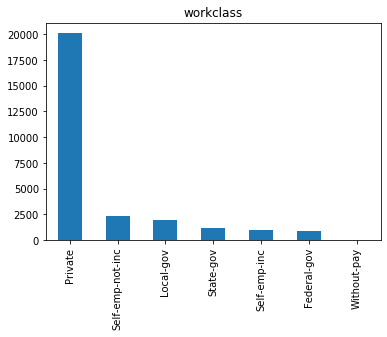

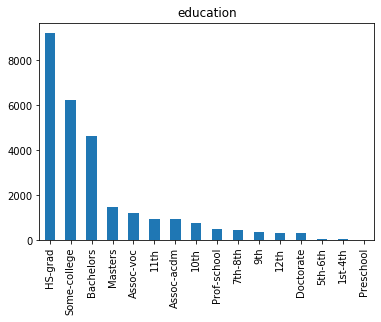

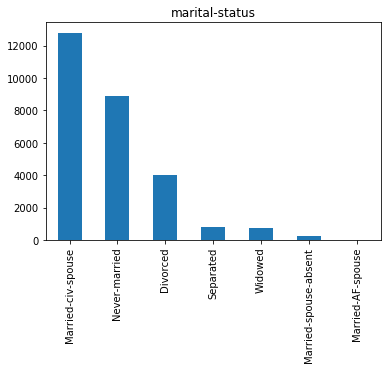

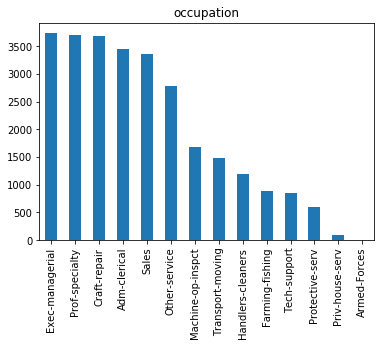

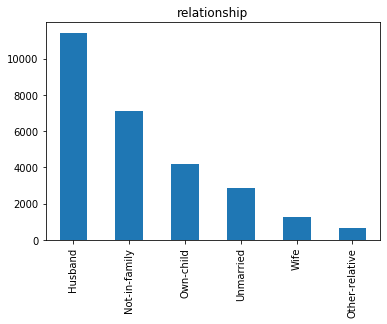

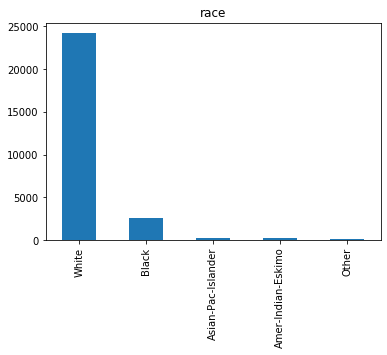

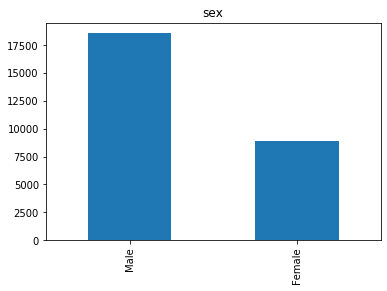

In [11]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

## Visualize the continuous feautures

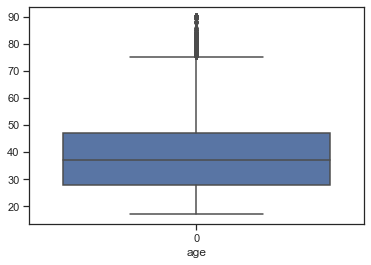

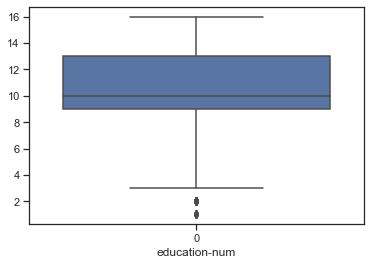

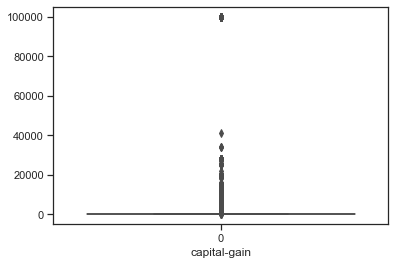

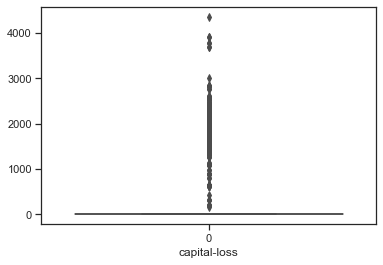

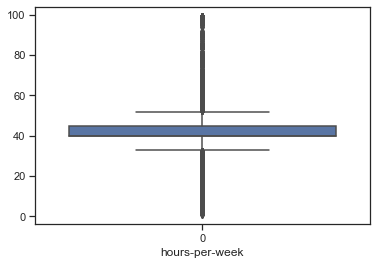

In [12]:
# to do
sns.set(style="ticks", color_codes=True)

string_columns = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

for col in string_columns: 
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=df[col]).set(
    xlabel=col
)


### One hot encode

In [13]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [14]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [15]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [16]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [17]:
new_df = new_df.reset_index()

In [18]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Permutate/Shuffle the dataframe before applying algorithms

In [19]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
4644,4644,39,111499,13,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
19548,19548,31,126501,11,0,0,40,1,0,0,...,0,1,0,0,0,0,0,0,1,0
11521,11521,42,154374,9,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,1
14739,14739,51,139347,9,7688,0,40,0,0,1,...,0,0,0,1,0,0,0,0,1,1
13993,13993,40,182140,9,0,0,40,0,0,1,...,0,0,1,0,0,0,1,0,0,0
17369,17369,43,35034,13,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17202,17202,41,287037,10,0,0,40,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8618,8618,35,202027,10,0,0,60,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1162,1162,19,119075,10,0,0,50,0,0,1,...,0,1,0,0,0,0,0,0,1,0
7514,7514,22,249727,10,0,0,20,0,0,1,...,0,1,0,0,0,0,0,0,1,0


### Drop final weight (we don't need it)

In [20]:
new_df.drop(columns = ['fnlwgt'],inplace = True)
new_df.head(10)

,index,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
4644,4644,39,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
19548,19548,31,11,0,0,40,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
11521,11521,42,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
14739,14739,51,9,7688,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1
13993,13993,40,9,0,0,40,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
17369,17369,43,13,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17202,17202,41,10,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8618,8618,35,10,0,0,60,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1162,1162,19,10,0,0,50,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
7514,7514,22,10,0,0,20,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [21]:
# Look at the class imbalance

In [22]:
df['income'].value_counts()

<=50K    20509
>50K      6995
Name: income, dtype: int64

### Get indexes for each individual feature and their respective names

In [23]:
ranges = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,13],[13,20],[20,34],[34,40],[40,45],[1,45]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Function to return results for each classifier

In [24]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()

    duration = time.time() - start_time

    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()
    
    return [scores, clf.score(X_train,Y_train), score_f1, duration]

### Classifiers we will use with different initializations

In [25]:
#classifiers we will use with different initializations
classifiers = [SVC(kernel = 'linear',gamma ='auto',random_state = 50)]
classifiers.append(SVC(kernel = 'linear',gamma ='auto',random_state = 50,class_weight = 'balanced'))
classifiers.append(MLPClassifier(activation = 'relu',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(4, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.

### Name of the Classifiers

In [26]:
names = ['SVM with Linear Kernel','SVM with Linear Kernel and balanced class weight',
         'Neural Network with ReLU activation',
         'Neural Network with Logistic Sigmoid activation',
         'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent label']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

3.2346608638763428 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


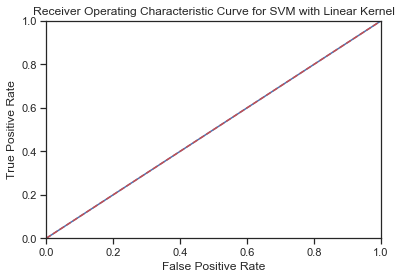


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Age ----------

9.138831853866577 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6242330591283007
Using Age as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6236363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2438       1641
True >50k        465        957

F1-score is: 0.4761194029850746


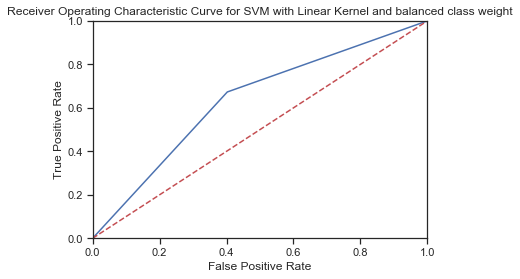


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.259976863861084 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


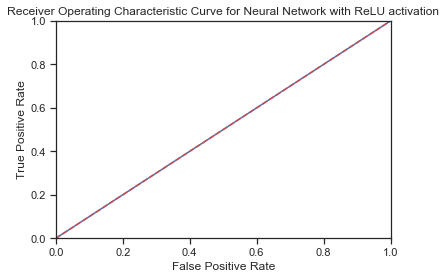


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.21925592422485352 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


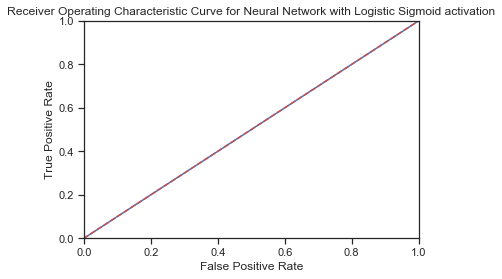


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.3876338005065918 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


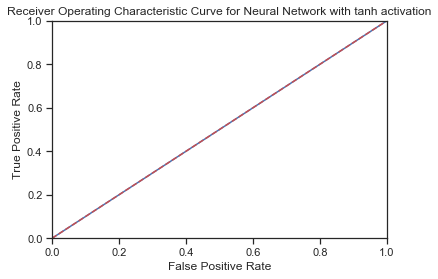


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Age ----------

0.0026340484619140625 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Age as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


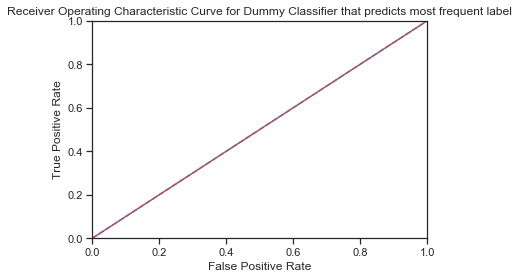


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

4.612415075302124 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


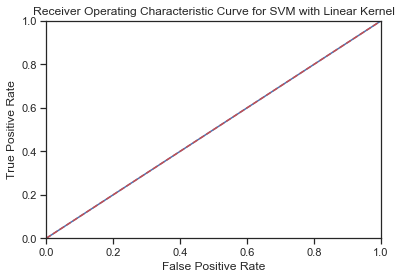


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Education ----------

7.866931915283203 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7290369495068855
Using Education as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3247        832
True >50k        702        720

F1-score is: 0.4841963685272361


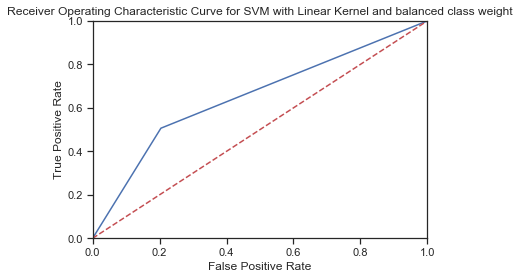


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.3264930248260498 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7690769440530837
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7654971823304854

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3910        169
True >50k       1121        301

F1-score is: 0.3181818181818182


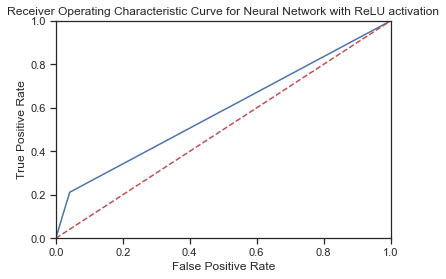


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.34832215309143066 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7690769440530837
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7654971823304854

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3910        169
True >50k       1121        301

F1-score is: 0.3181818181818182


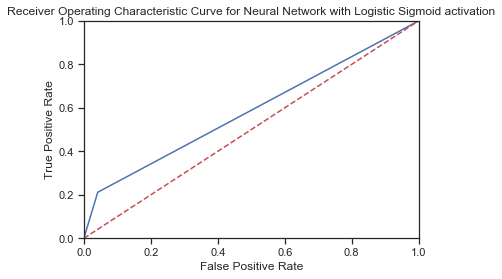


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.2389202117919922 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7690769440530837
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7654971823304854

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3910        169
True >50k       1121        301

F1-score is: 0.3181818181818182


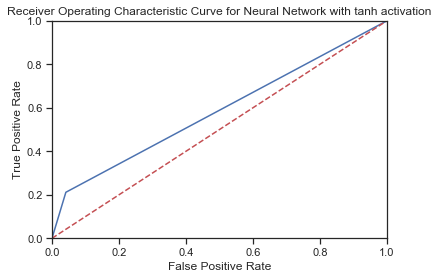


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Education ----------

0.0025300979614257812 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Education as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


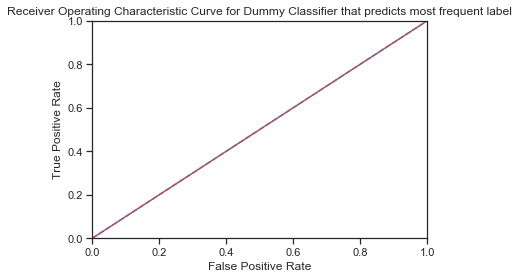


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

2.0521228313446045 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7852565559241922
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7916287534121929

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4019         60
True >50k       1120        302

F1-score is: 0.3385650224215247


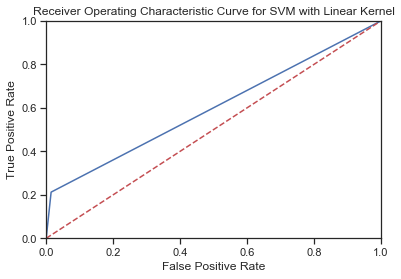


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Gain ----------

4.5194361209869385 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7784847520792619
Using Capital Gain as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7907188353048226

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3972        107
True >50k       1104        318

F1-score is: 0.3443421765024364


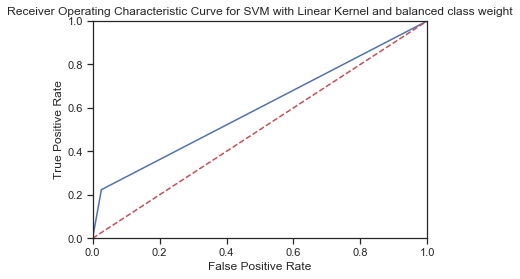


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.5934498310089111 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7915284279416444
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7907653153972005

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4067         12
True >50k       1139        283

F1-score is: 0.3296447291788002


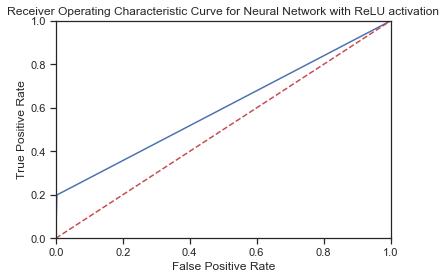


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.31996798515319824 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.788619733672681
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7889474640974369

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4054         25
True >50k       1136        286

F1-score is: 0.33006347374495093


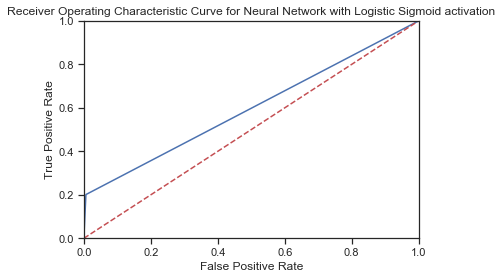


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.1953139305114746 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7883015952370132
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.788038538447555

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4067         12
True >50k       1154        268

F1-score is: 0.3149236192714454


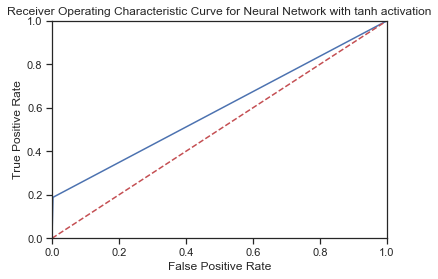


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Capital Gain ----------

0.002562999725341797 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


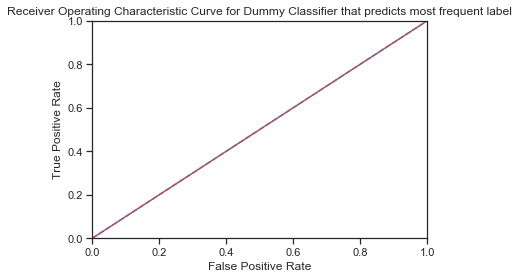


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

2.1907551288604736 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7498522928691542
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.75

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3965        114
True >50k       1295        127

F1-score is: 0.15273601924233315


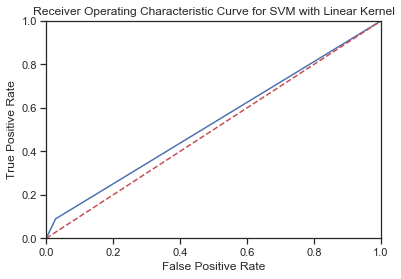


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Capital Loss ----------

5.163563013076782 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.749670499477344
Using Capital Loss as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.75

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3962        117
True >50k       1295        127

F1-score is: 0.1524609843937575


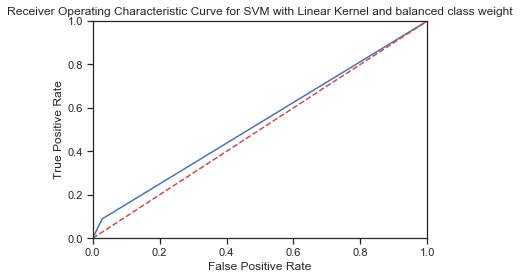


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.08560895919799805 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.761441621597055
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.754953644791856

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4040         39
True >50k       1309        113

F1-score is: 0.14358322744599747


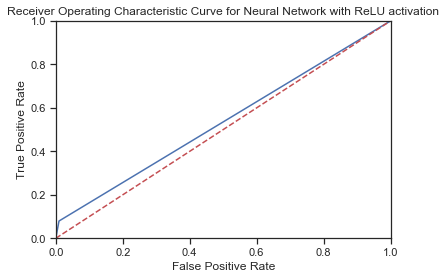


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.34247493743896484 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7613961732491024
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7553172150518087

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4040         39
True >50k       1307        115

F1-score is: 0.14593908629441624


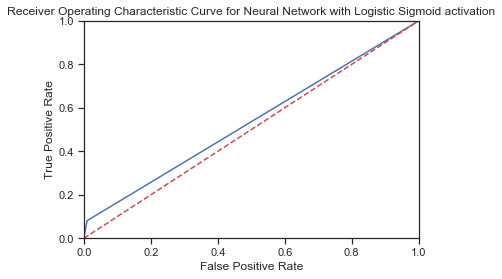


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.4538240432739258 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7613961732491024
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7553172150518087

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4040         39
True >50k       1307        115

F1-score is: 0.14593908629441624


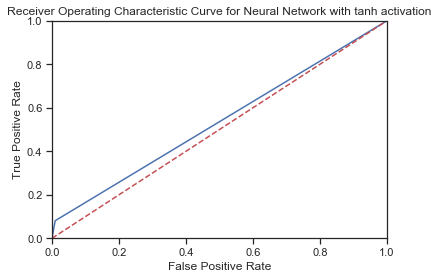


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Capital Loss ----------

0.0021708011627197266 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


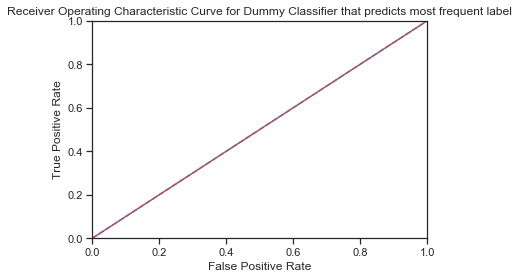


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

4.697548151016235 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


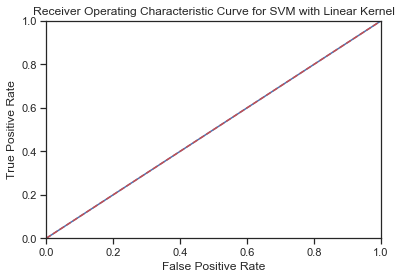


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Hours Per Week ----------

9.137499809265137 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6904058537472163
Using Hours Per Week as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7072727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3078       1001
True >50k        701        721

F1-score is: 0.4586513994910941


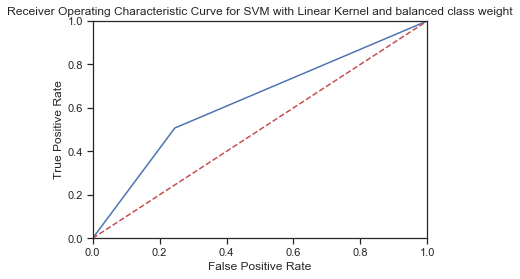


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.23077130317687988 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


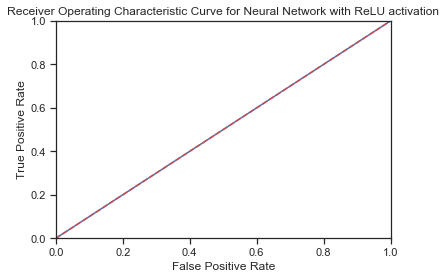


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.14735817909240723 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


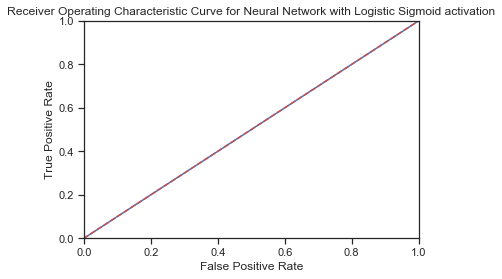


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.1253221035003662 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


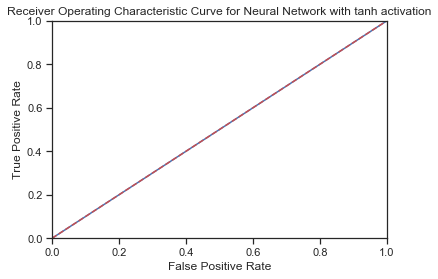


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Hours Per Week ----------

0.0020918846130371094 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


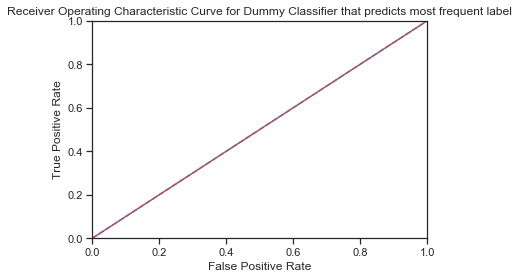


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

3.690006971359253 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7515793300913511
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3988         91
True >50k       1313        109

F1-score is: 0.1344019728729963


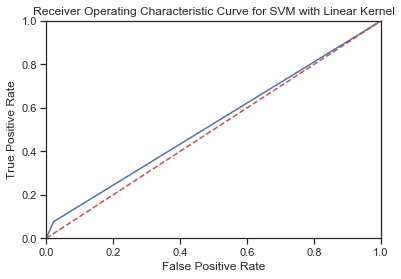


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Workclass ----------

7.884047269821167 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6577739399172841
Using Workclass as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6918181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3100        979
True >50k        934        488

F1-score is: 0.3378331602630668


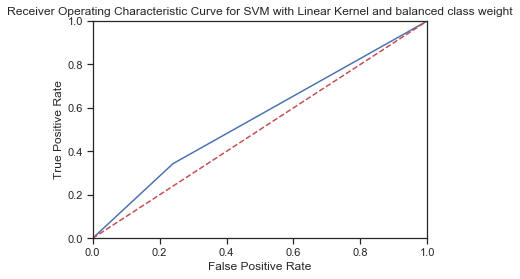


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.6064813137054443 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7515793300913511
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7447736775131795

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3988         91
True >50k       1313        109

F1-score is: 0.1344019728729963


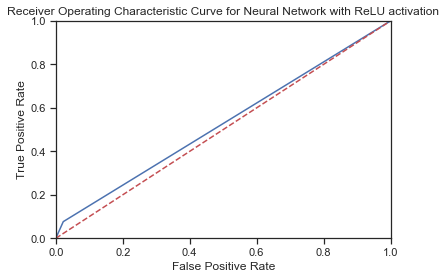


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.21564626693725586 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7515793300913511
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7447736775131795

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3988         91
True >50k       1313        109

F1-score is: 0.1344019728729963


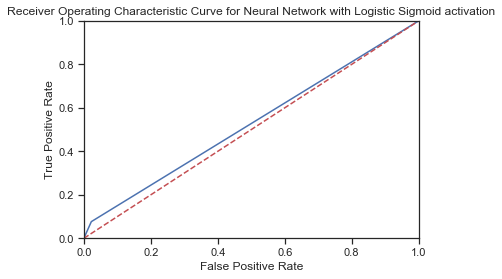


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.17083096504211426 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7515793300913511
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7447736775131795

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3988         91
True >50k       1313        109

F1-score is: 0.1344019728729963


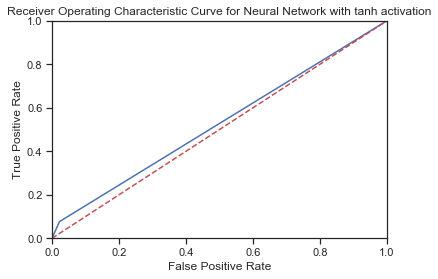


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Workclass ----------

0.0024950504302978516 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


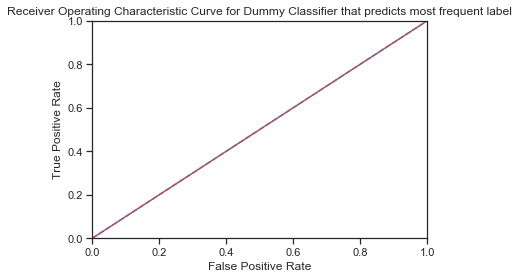


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

4.282939195632935 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


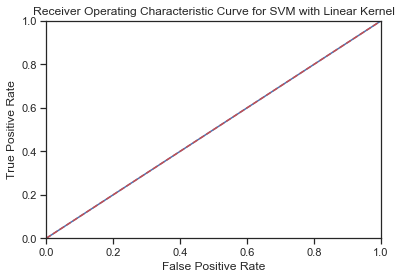


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Marital Status ----------

4.75813102722168 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7144480298141163
Using Marital Status as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7184377838328792

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2723       1356
True >50k        237       1185

F1-score is: 0.5980317940953823


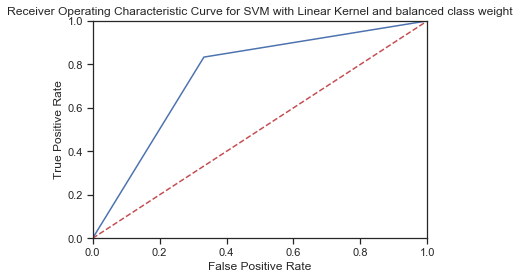


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.2769300937652588 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


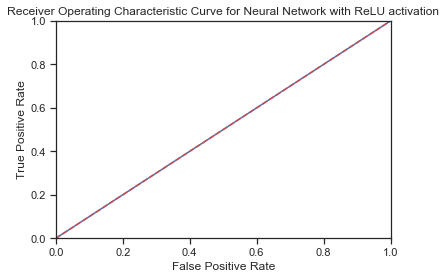


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.24695134162902832 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


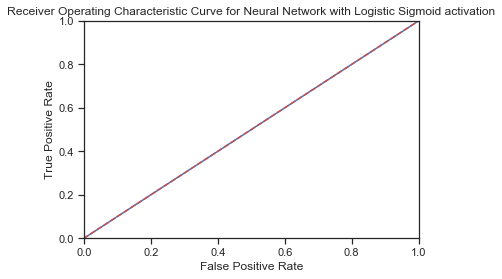


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.2139730453491211 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7413197600436284

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4077          2
True >50k       1421          1

F1-score is: 0.0014035087719298247


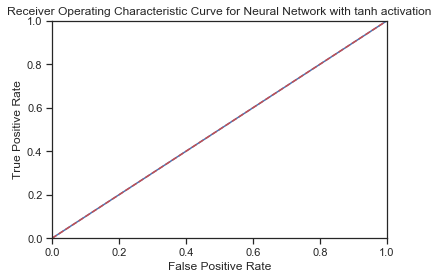


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Marital Status ----------

0.002625703811645508 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


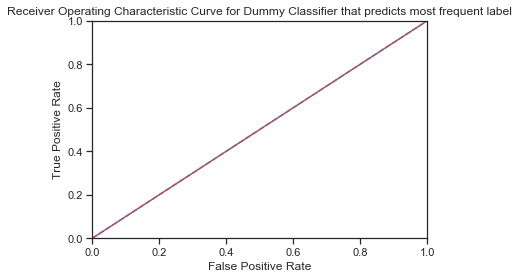


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

6.298558950424194 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


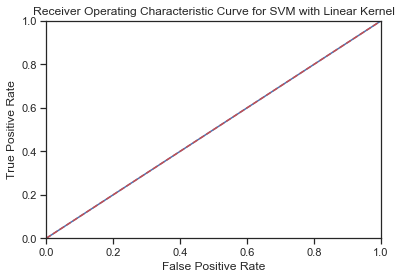


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Occupation ----------

9.771433115005493 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.6573649047857111
Using Occupation as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.6372727272727273

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2557       1522
True >50k        470        952

F1-score is: 0.48870636550308005


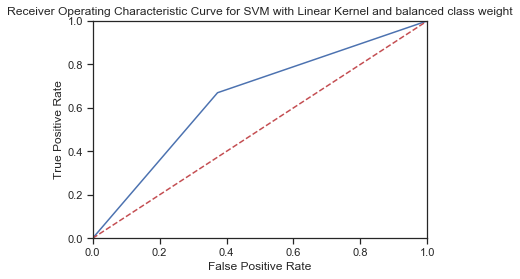


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

0.24324774742126465 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


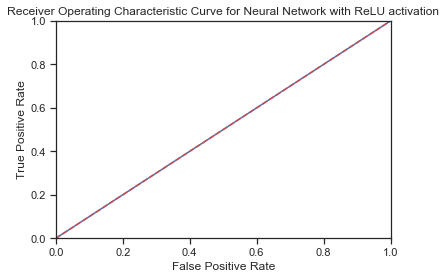


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.33871006965637207 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


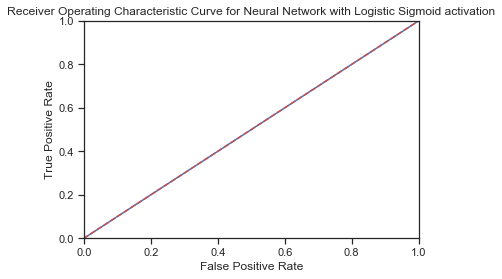


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

0.5113263130187988 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


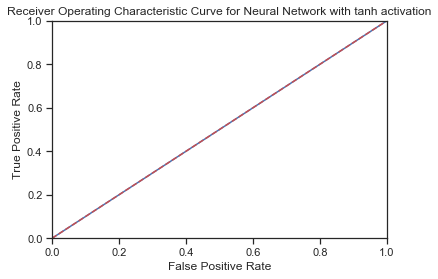


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Occupation ----------

0.002458333969116211 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


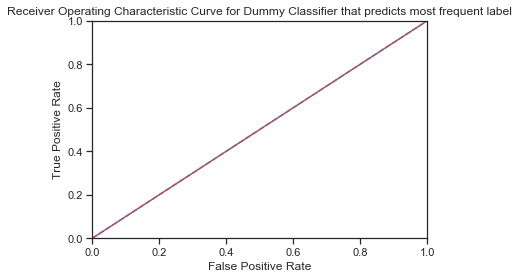


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

4.396999835968018 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7556766575840145

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


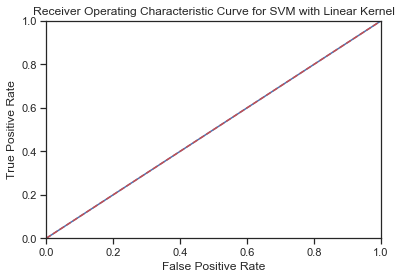


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Relationship ----------

4.836785078048706 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7177657592146526
Using Relationship as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7209090909090909

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2753       1326
True >50k        245       1177

F1-score is: 0.5997452229299363


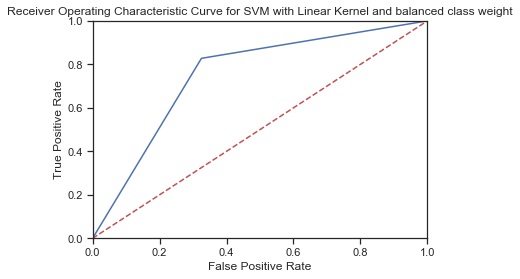


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.362246036529541 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


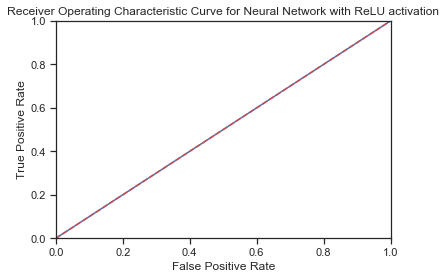


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.2918357849121094 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


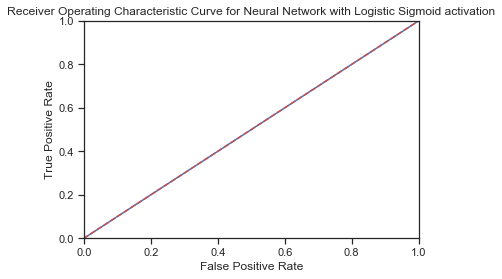


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.2543299198150635 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


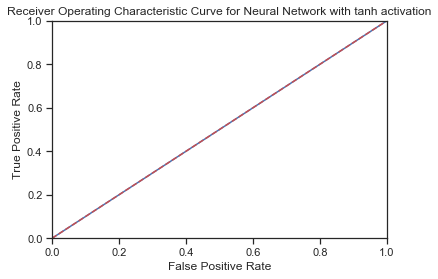


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Relationship ----------

0.0025930404663085938 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


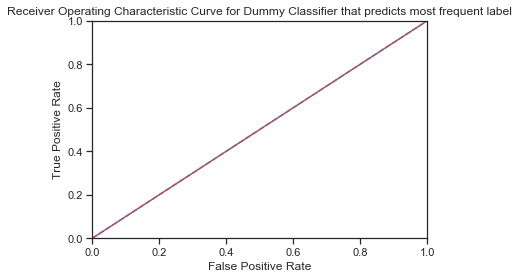


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

3.2243659496307373 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7467163568604281
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7418181818181818

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


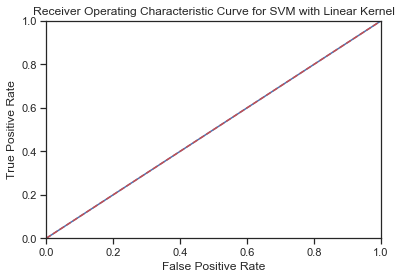


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: Race ----------

6.309605121612549 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.33972640094532564
Using Race as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.35545454545454547

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k        565       3514
True >50k         93       1329

F1-score is: 0.4242617717478052


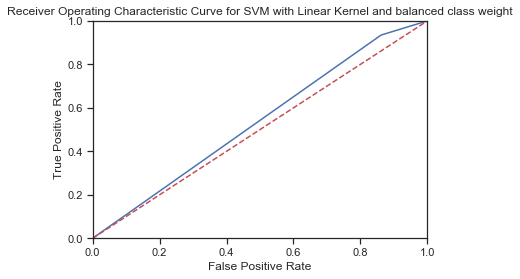


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.1800830364227295 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7467163568604281
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


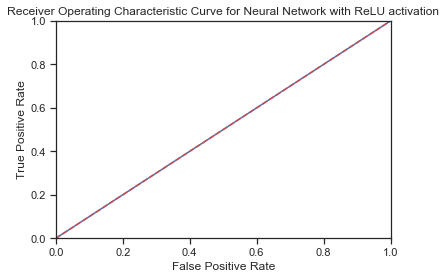


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.20737791061401367 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7467163568604281
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


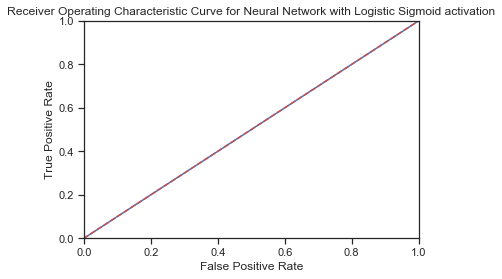


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.16963624954223633 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7467163568604281
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


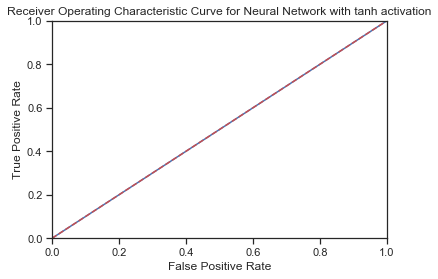


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: Race ----------

0.0024170875549316406 seconds for  Dummy Classifier that predicts most frequent label  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using Race as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


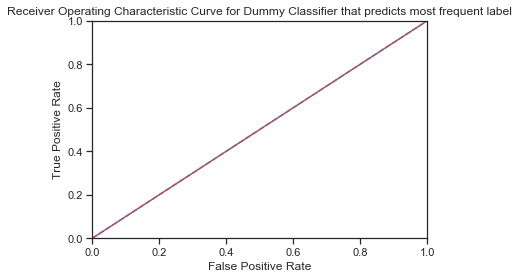


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

25.11539387702942 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8471117574876154
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.8453139217470428

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3790        289
True >50k        607        815

F1-score is: 0.6452889944576405


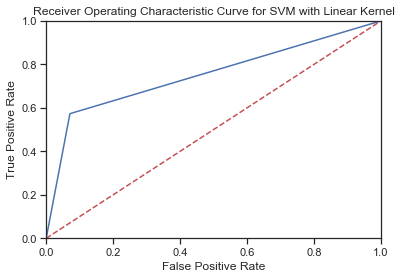


---------- Results Summary for SVM with Linear Kernel and balanced class weight for the column: All Columns ----------

30.67445707321167 seconds for  SVM with Linear Kernel and balanced class weight  to train
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get train accuracy of:  0.7918011180293596
Using All Columns as a predictor for  SVM with Linear Kernel and balanced class weight  we get test accuracy of:  0.7970882620564149

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3169        910
True >50k        220       1202

F1-score is: 0.6802490096208262


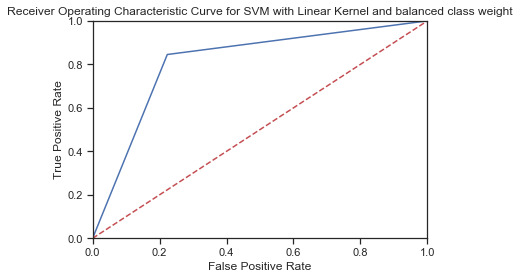


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

1.585420846939087 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.855974185338363
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8425740774404654

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3773        306
True >50k        560        862

F1-score is: 0.6656370656370656


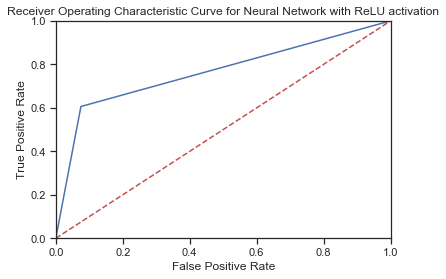


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

1.6781580448150635 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8546107348997863
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.8407562261407017

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3771        308
True >50k        568        854

F1-score is: 0.6609907120743034


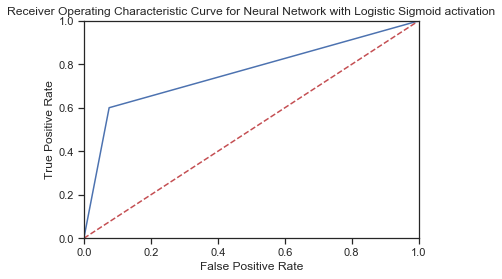


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

1.548886775970459 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.855156115075217
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.8429376477004181

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3775        304
True >50k        560        862

F1-score is: 0.6661514683153014


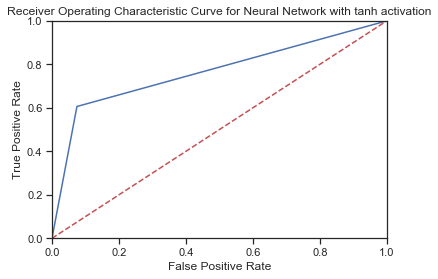


---------- Results Summary for Dummy Classifier that predicts most frequent label for the column: All Columns ----------

0.003387928009033203 seconds for  Dummy Classifier that predicts most frequent label  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent label  we get train accuracy of:  0.7467163568604281
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent label  we get test accuracy of:  0.7415015451736048

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4079          0
True >50k       1422          0

F1-score is: 0.0


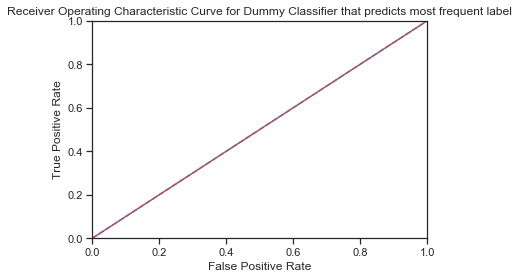

In [27]:
Y = np.array(new_df.iloc[:,45:46]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

# matrizes with the quality criteria
test_accuracies = np.zeros((len(ranges), len(classifiers)))
train_accuracies = np.zeros((len(ranges), len(classifiers)))
f1_scores = np.zeros((len(ranges), len(classifiers)))
duration = np.zeros((len(ranges), len(classifiers)))

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 0 or j == 1:   # if it is svm do cross validation
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],True,False,i)
        elif j == 5:  # if it is a dummyclassifier, calculate accuracy the proper way 
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],False,True,i)
        else:    # if a regular classifier, just do the normal operations
            test_accuracies[i,j],train_accuracies[i,j],f1_scores[i,j], duration[i,j] = return_results(classifiers[j],names[j],False,False,i)

In [28]:
names

['SVM with Linear Kernel',
 'SVM with Linear Kernel and balanced class weight',
 'Neural Network with ReLU activation',
 'Neural Network with Logistic Sigmoid activation',
 'Neural Network with tanh activation',
 'Dummy Classifier that predicts most frequent label']

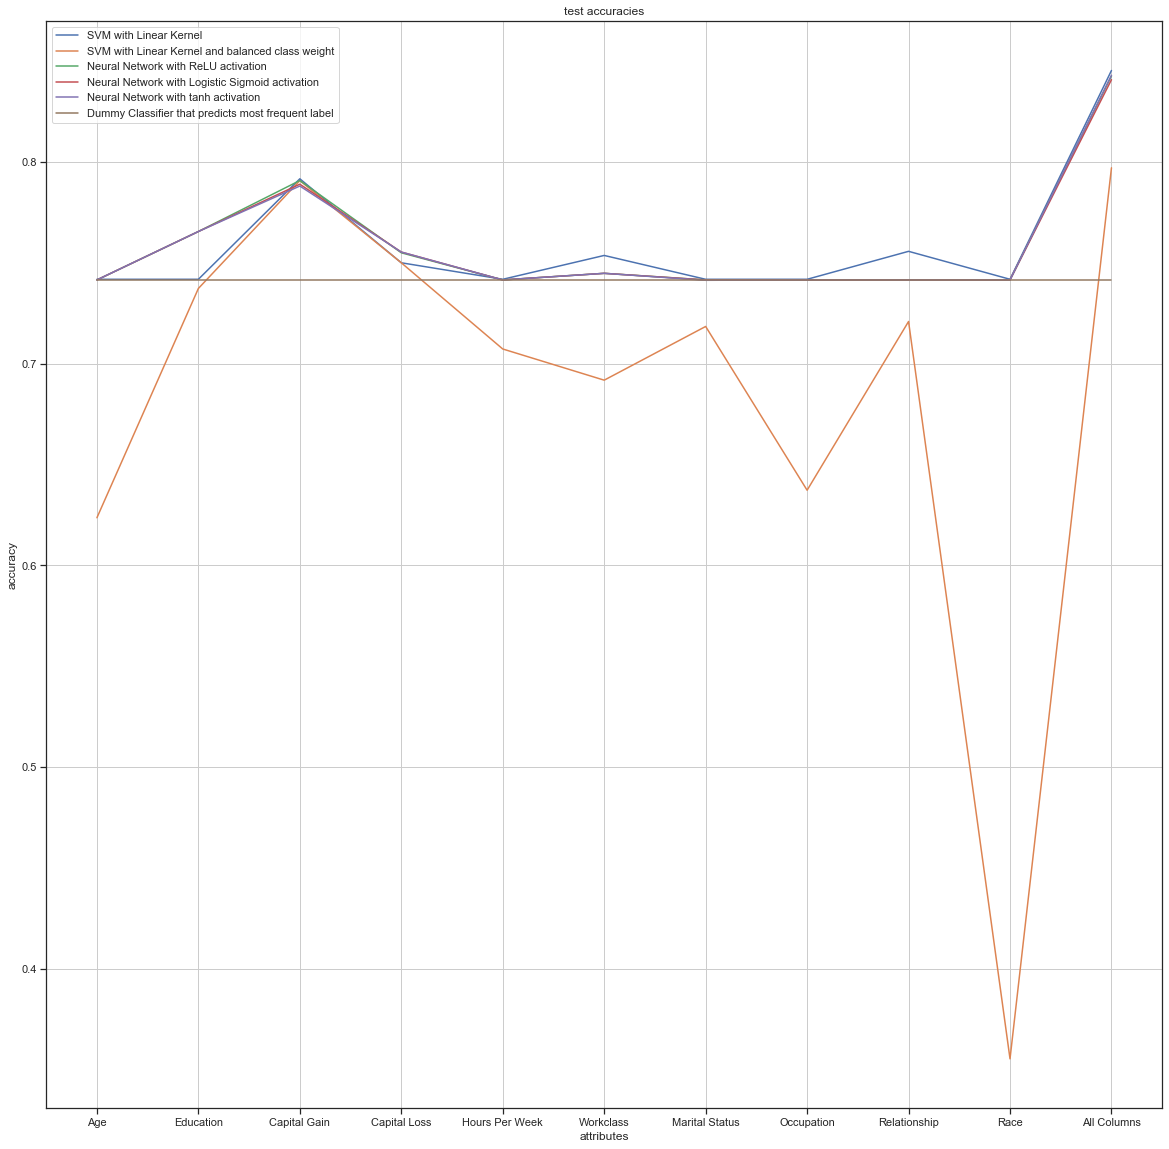

In [29]:
## Visualizing test accuracy

test_accuracies_svm_LK = test_accuracies[:,0]
test_accuracies_svm_LK_cw = test_accuracies[:,1]
test_accuracies_NN_ReLU = test_accuracies[:,2]
test_accuracies_NN_LSa = test_accuracies[:,3]
test_accuracies_NN_tanh = test_accuracies[:,4]
test_accuracies_DCLF = test_accuracies[:,5]


plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(columns, test_accuracies_svm_LK, label= names[0])
ax.plot(columns, test_accuracies_svm_LK_cw, label = names[1])
ax.plot(columns, test_accuracies_NN_ReLU, label = names[2])
ax.plot(columns, test_accuracies_NN_LSa, label = names[3])
ax.plot(columns, test_accuracies_NN_tanh, label = names[4])
ax.plot(columns, test_accuracies_DCLF, label = names[5])


ax.set(xlabel='attributes', ylabel='accuracy',
       title='test accuracies')
ax.grid()
plt.legend()

fig.savefig("test_accuracies.png")

plt.show()

print('test accuracies: ',
     test_accuracies)

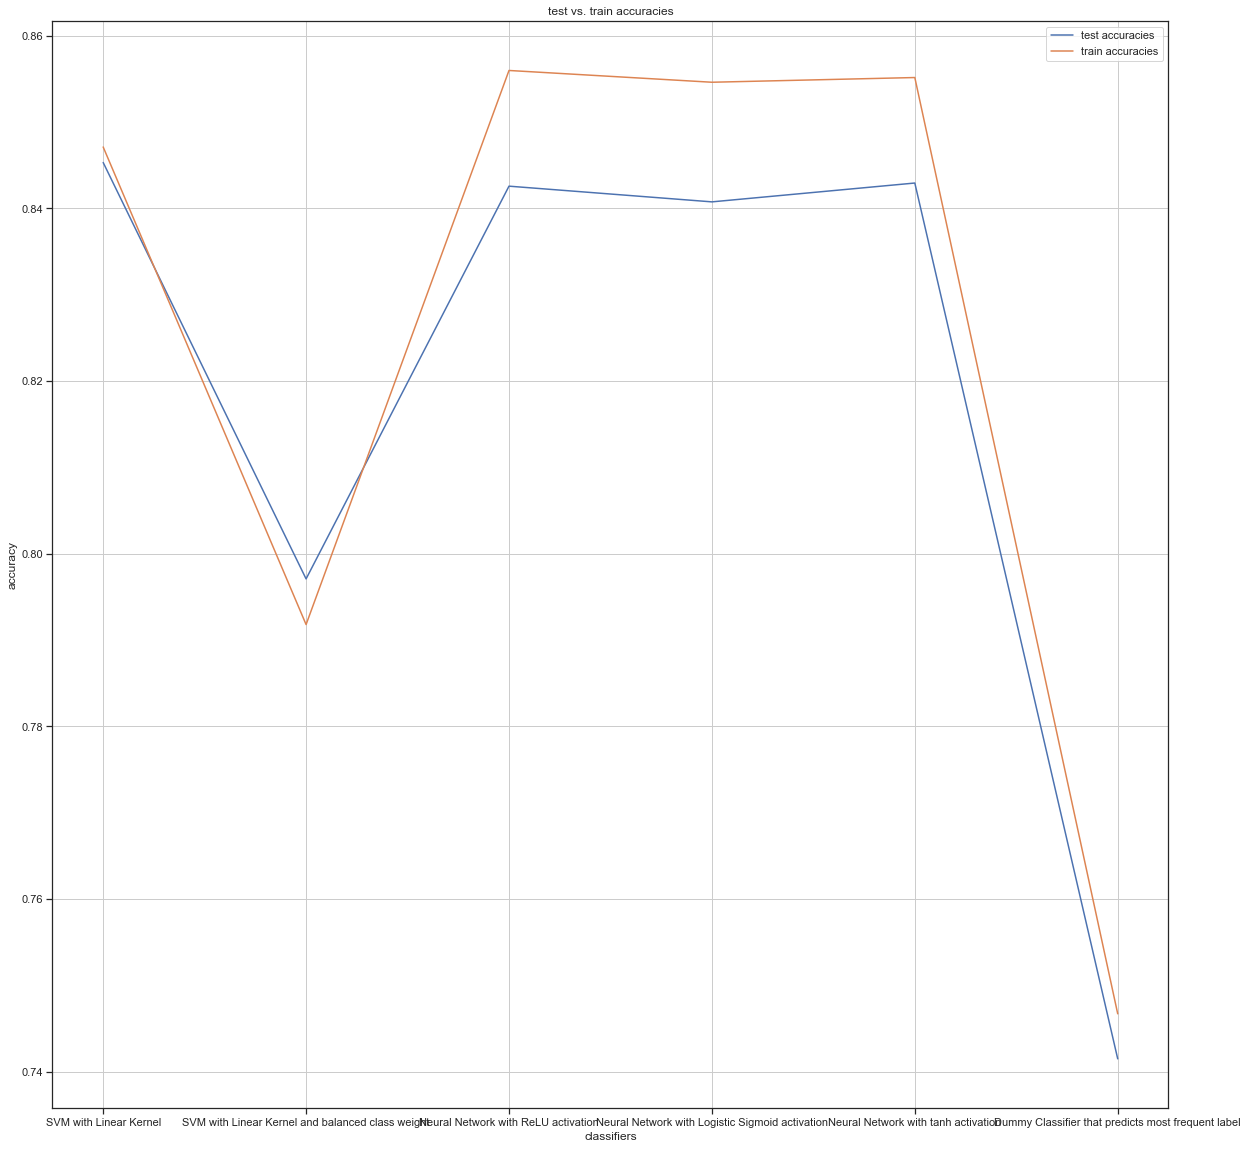

In [30]:
# visualizing test versus train accuracy

plt.rcParams["figure.figsize"] = (20,20)

test_acc_all_var = test_accuracies[-1,:]
train_acc_all_var = train_accuracies[-1,:]

fig, ax = plt.subplots()
ax.plot(names, test_acc_all_var, label= 'test accuracies')
ax.plot(names, train_acc_all_var, label= 'train accuracies')



ax.set(xlabel='classifiers', ylabel='accuracy',
       title='test vs. train accuracies')
ax.grid()
plt.legend()

fig.savefig("test_vs_train_accuracies.png")

plt.show()

print('train accuracies for all variables: ', 
      test_acc_all_var)
print('testaccuracies for all variables: ', 
      train_acc_all_var)

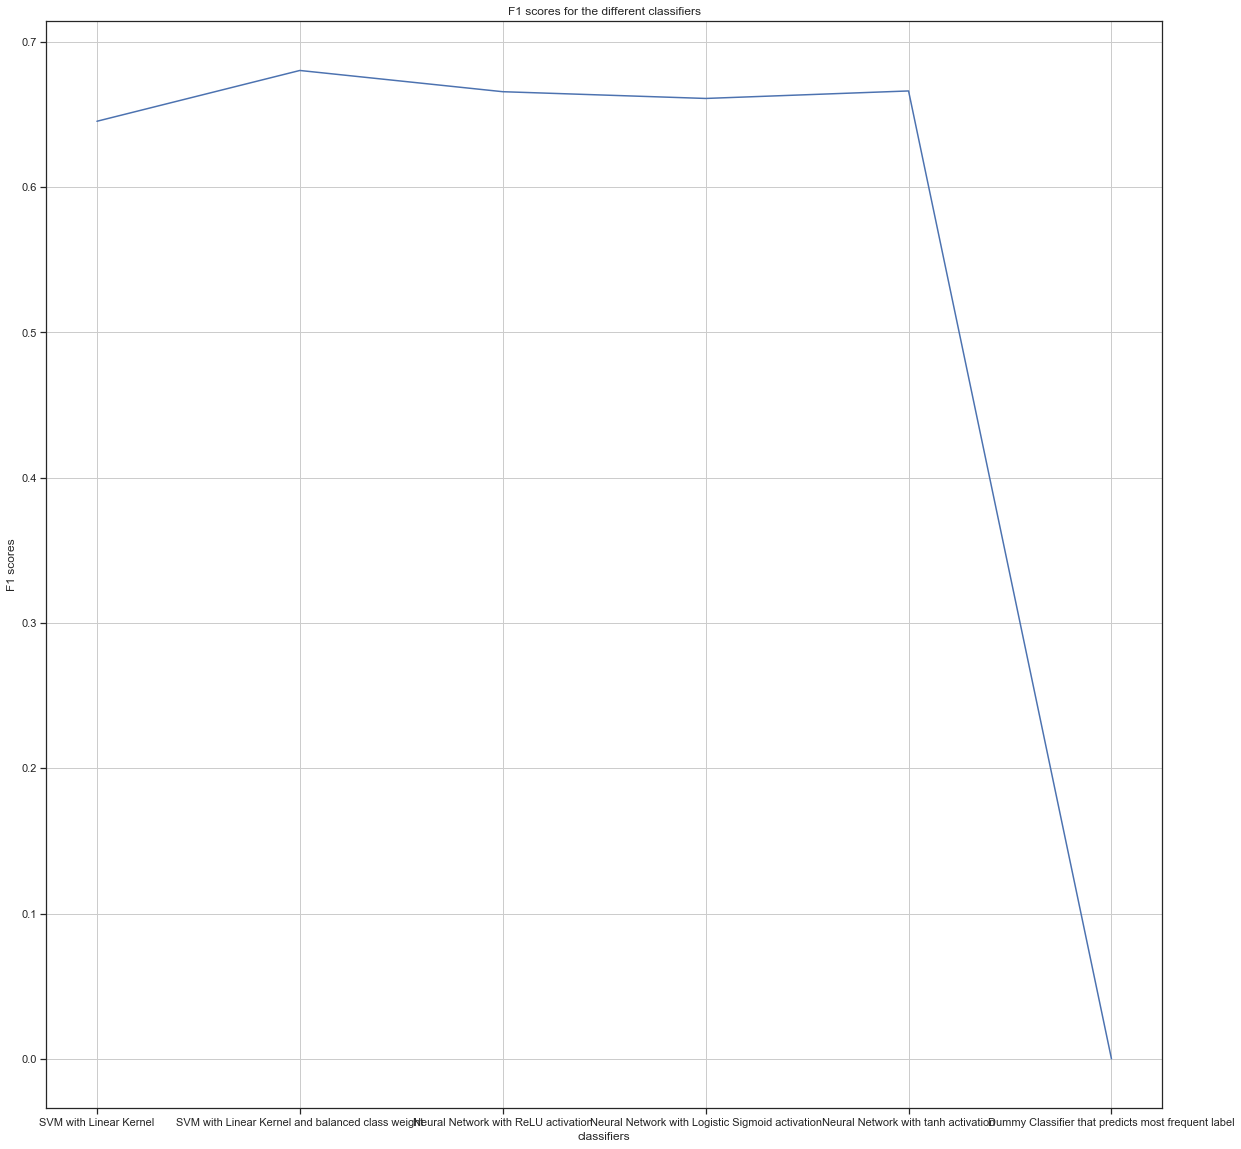

In [31]:
# plot F1 scores

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(names, f1_scores[-1,:])


ax.set(xlabel='classifiers', ylabel='F1 scores',
       title='F1 scores for the different classifiers')
ax.grid()

fig.savefig("F1_scores.png")

plt.show()

print(f1_scores[-1,:])

In [ ]:
# visualizing how long the classifier takes to train

plt.rcParams["figure.figsize"] = (20,20)

fig, ax = plt.subplots()
ax.plot(names, duration[-1,:])


ax.set(xlabel='classifiers', ylabel='time for training',
       title='Time to train for each classifier')
ax.grid()

fig.savefig("training_time.png")

plt.show()

print(duration[-1,:])